# Validity of postprocessing

We postprocess the data to offload the computational costs of filtering and averaging to SLURM parallel jobs. Working with spatially averaged data should be faster. 

The postprocessing encompasses the following:

1. joins 2D fields and 2D radiation into one dataset (`get_data`)
2. joins data from the control and the warming experiment (`add_control`, adding the dimension 'exp')
3. discards the edges (cutting out a smaller patch) (`get_data`)
4. adds derived energy balance terms (`add_variables`)
5. discards cells with ice clouds (`pp.filter_by_threshold`)
6. drops `NaN` values (`process_dataset`)
7. splits the dataset in cloudy and non-cloudy cells (adding the dimension `cloudcover` with values `[0,1]`), plus the whole dataset (as value `0.5`; `cloud_filter`)
8. averages spatially (`data.mean(dim='cell')`)

The validity of this has to be proved. We use the incoming solar radiation for this, as it should not vary significantly between cloudy and non-cloudy cells and should not vary at all between experiments.


## Problem
When I filter for ice values in a non spatially uniform field, I introduce a bias. 
This might not be important if i only look at deltas between the runs, but it might render absolute values unusable.



## TODO
- make plots to show the problem
- make plots to prove the problem source hypothesis
- ice cloud cover time series to assess the importance of the problem
- make this more readable
- rewrite postprocessing with job arrays
- do i have to move more data?

In [2]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data

def get_processed(time_index):
    data = get_data()
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-5}, below_threshold=True)
    data = process_dataset(data)
    data = cloud_filter(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data
    

In [ ]:
time_array = get_data().time
print(len(time_array))

In [3]:
i = 187
file_name = f'/scratch/m/m300872/temp2/{str(i)}.nc'
var = 'sod_t'

d1 = get_processed(i)
print(d1.time.values)
d1.to_netcdf(file_name)
d2 = xr.open_dataset(file_name)
print(d1[var].values - d2[var].values)

/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dim

[[0. 0.]
 [0. 0.]
 [0. 0.]]


In [41]:
import os

def library():
    return """import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np
import os

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data
    
def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    # data = pp.random_subsample(data, {{'cell':10000}})
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-5}, below_threshold=True)
    data = process_dataset(data)
    data = cloud_filter(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data
"""
    
def body(time_index, ofile=None, domain='DOM01'):
    if ofile == None: ofile = f'/scratch/m/m300872/temp/rad_{domain}_{str(time_index[0]).rjust(4, str(0))}-{str(time_index[-1]).rjust(4, str(0))}.nc'
    body = ('\n'
            f'domain = "{domain}" \n'
            f'time_index = {time_index} \n'
            f'ofile = "{ofile}"\n'
            'dateformat = "%Y-%m-%d-%H:%M" \n'
            'print(time_index) \n'
            'print("\t", ofile) \n'
            'data = get_processed(time_index=time_index, domain=domain) \n'
            'for t in data.time.values: \n'
            '    ofile_t = os.path.join(os.path.dirname(ofile), f"pp_{pd.to_datetime(t).strftime(dateformat)}.nc") \n'
            '    if not os.path.exists(ofile_t): \n'
            '        d = data.sel(time=[t]) \n'
            '        d.to_netcdf(ofile_t) \n'
            ' \n'
            'print("\tdone")')
    return body

def header():
    return fh.slurm_header( minutes=120,
                            partition='compute',
                            account='bm1183',
                            email='hernan.campos@mpimet.mpg.de',
                            job_name='mean',
                            return_string=True)

domain, n_lists = 'DOM02', 40
domain, n_lists = 'DOM01', 800
domain, n_lists = 'DOM01', 100
domain, n_lists = 'DOM01', 20
domain, n_lists = 'DOM01', 200

# data = pp.random_subsample(data, {{'cell':10000}}), suffix='sub1e4_'

time_array = get_data(domain=domain).time
time_array

jobs  = list()
files = list()
for i in range(n_lists):
    time_indices = list(range(len(time_array)))
    time_indices = fh.sublist(time_indices, n_lists, i)
    ofile = f'/scratch/m/m300872/temp/rad_{domain}_{str(time_indices[0]).rjust(4, str(0))}.nc'
    ofile = f'/scratch/m/m300872/temp/rad_{domain}_n{str(n_lists)}_{str(time_indices[0]).rjust(4, str(0))}-{str(time_indices[-1]).rjust(4, str(0))}.nc'
    script = header()+library()+body(time_indices, ofile, domain)
    if not os.path.exists(ofile):
        jobid = fh.launch_slurm_script(script)
        jobs.append(jobid)
    else:
        files.append(ofile)
len(jobs, jobs[0])

/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dim

IndexError: list index out of range

## rewrite using slurm arrays

In [1]:
#!/usr/bin/env python3
#SBATCH --job-name='proc_2'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%15
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np
import os

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data

def ice_filter(data):
    filter_dict = {'tqi_dia':1e-5}
    unfiltered = data
    filtered = pp.filter_by_threshold(data, filter_dict, below_threshold=True)
    dimname, dimvalues = 'icefilter', [0, filter_dict['tqi_dia']]
    processed_data = xr.concat([unfiltered, filtered], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data
    
def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = ice_filter(data)
    data = cloud_filter(data)
    data = process_dataset(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

def _main():
    output_dir = '/scratch/m/m300872/temp'
    domain = 'DOM01'
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    
    time_array = get_data(domain=domain).time
    time_indices = list(range(len(time_array)))
    time_indices = fh.sublist(time_indices, task_count, task_id)
    
    dateformat = "%Y-%m-%d-%H:%M"
    data = get_processed(time_index=time_indices, domain=domain)
    
    for t in data.time.values:
        ofile = os.path.join(output_dir, f"pp_{pd.to_datetime(t).strftime(dateformat)}.nc")
        print(ofile)
        if not os.path.exists(ofile):
            d = data.sel(time=[t])
            print('\twriting')
            d.to_netcdf(ofile)
        else:
            print('\texists')
    print('\tdone\n')
    
if fh.is_running_in_notebook():
    print('In notebook. Not executed.')
elif __name__ == "__main__":
    _main()

In notebook. Not executed.


In [ ]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='proc_4'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%15
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np
import os

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]                                                                                                                         
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data

def ice_filter(data):
    filter_dict = {'tqi_dia':1e-5}
    unfiltered = data
    filtered = pp.filter_by_threshold(data, filter_dict, below_threshold=True)
    dimname, dimvalues = 'icefilter', [0, filter_dict['tqi_dia']]
    processed_data = xr.concat([unfiltered, filtered], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data
    
def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = ice_filter(data)
    data = cloud_filter(data)
    data = process_dataset(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

def _main():
    domain = 'DOM01'
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    print(os.environ.get("SLURM_JOB_NAME", 0), f'({task_id}/{task_count})')

    time_array = get_data(domain=domain).time
    time_indices = list(range(len(time_array)))
    time_indices = fh.sublist(time_indices, task_count, task_id)
    print(f'working on {len(time_indices)} time steps ({time_indices[0]} - {time_indices[-1]})')
    
    output_dir = '/scratch/m/m300872/temp/'
    dateformat = "%Y-%m-%d-%H:%M"
    data = get_processed(time_index=time_indices, domain=domain)
    print('start iteration')                                                                                                                                               
    print()
    for t in data.time.values:
        ofile = os.path.join(output_dir, f"pp_{pd.to_datetime(t).strftime(dateformat)}.nc")
        print(ofile, os.path.exists(ofile))
        if not os.path.exists(ofile):
            d = data.sel(time=[t])
            d.to_netcdf(ofile)
        print("\tdone")
    print('all done')
    
if fh.is_running_in_notebook():
    print('In notebook. Not executed.')
elif __name__ == "__main__":
    _main()        

## whats the effect of ice filtering on my data?

2020-01-10 17:50:00
cloudcover 0.0 962.4683
cloudcover 0.5 963.17413
cloudcover 1.0 965.5296
icefilter 0.0 963.712
icefilter 1e-05 963.736
exp warming 964.0183
exp control 963.42975


/tmp/ipykernel_2110184/12760423.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim in ds.dims.keys():


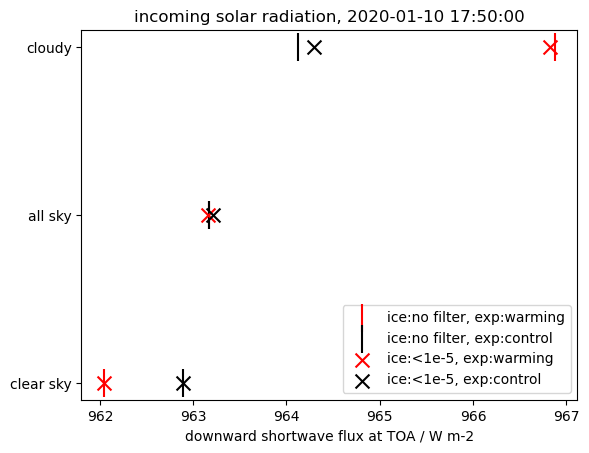

In [78]:
import matplotlib.pyplot as plt

ds = xr.open_dataset(f'/scratch/m/m300872/temp2/if_{str(187)}.nc')
print(pd.to_datetime(ds.time.values))
var = 'sod_t'

for dim in ds.dims.keys():
    for v in ds[dim].values:
        print(dim, v, ds.sel({dim:v})[var].mean().values)

fig, ax = plt.subplots()
# ds[var].plot(x='cloudcover')

for ice in ds['icefilter'].values:
    for exp in ds['exp'].values:
        sel_dict = dict(icefilter=ice, exp=exp)
        # print(ds.sel(icefilter=ice).sel(exp=exp)[var].values)
        # ds.sel(icefilter=ice).sel(exp=exp)[var].plot(ax=ax, label=sel_dict)
        color = 'black' if exp == 'control' else 'red'
        ls = '-' if ice == 0 else ':'
        marker = '|' if ice == 0 else 'x'
        s = 400 if ice == 0 else 100
        x = ds.cloudcover.values
        y = ds.sel(sel_dict)[var].values
        # ds.sel(sel_dict)[var].plot(ax=ax, label=sel_dict, color=color, ls=ls)
        ax.scatter(y,x, label=f'ice:{"no filter" if sel_dict["icefilter"] == 0 else "<1e-5"}, exp:{sel_dict["exp"]}', color=color, marker=marker, s=s)

# Set custom y-axis labels
y_labels = {0: 'clear sky', 0.5: 'all sky', 1: 'cloudy'}
ax.set_yticks(list(y_labels.keys()))
ax.set_yticklabels(list(y_labels.values()))
ax.set_xlabel(f"{ds[var].attrs['long_name']} / {ds[var].attrs['units']}")

ax.set_title(f'incoming solar radiation, {pd.to_datetime(ds.time.values)}')
ax.legend()

In [1]:
#!/usr/bin/env python3
#SBATCH --job_name='proc'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-39%4
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np
import os

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data

def ice_filter(data):
    filter_dict = {'tqi_dia':1e-5}
    unfiltered = data
    filtered = pp.filter_by_threshold(data, filter_dict, below_threshold=True)
    dimname, dimvalues = 'icefilter', [0, filter_dict['tqi_dia']]
    processed_data = xr.concat([unfiltered, filtered], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data
    
def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = ice_filter(data)
    data = cloud_filter(data)
    data = process_dataset(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data
    
def add_flag_variable(dataset, threshold_dict, flag_name='flag', below_threshold=False, chunk_size=None):
    """
    Add a flag variable to the dataset based on variable-specific thresholds.

    This function adds a new variable to the input dataset, which acts as a flag
    indicating whether each data point meets the specified threshold conditions.
    For each variable, the function creates a mask where values are compared against
    the threshold. The final flag is the result of combining these individual masks
    using a logical AND operation.

    Parameters:
    - dataset (xarray.Dataset): Input dataset to which the flag variable will be added.
    - threshold_dict (dict): Dictionary where keys are variable names and values are
      threshold values. The flag is created based on these thresholds.
    - flag_name (str): Name of the flag variable to be added to the dataset. Default is 'flag'.
    - below_threshold (bool): If True, values below the threshold are flagged as 1; if False,
      values above the threshold are flagged as 1. Default is False.
    - chunk_size (int or dict, optional): Chunk size to use for computation. If None,
      a heuristic is used to determine chunk size. Default is None.

    Returns:
    - dataset_with_flag (xarray.Dataset): Dataset with the added flag variable.
    """
    flag = xr.ones_like(dataset[list(threshold_dict.keys())[0]], dtype=int)
    for var_name, threshold in threshold_dict.items():
        if below_threshold:
            flag = flag & (dataset[var_name] < threshold)
        else:
            flag = flag & (dataset[var_name] > threshold)
    
    flag = flag.chunk(chunk_size)
    dataset[flag_name] = flag
    return dataset



def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data, clean=False, drop_vars=False)
    data = pp.cut_borders(data, varnames={'latitude':'clat', 'longitude':'clon'})
    return data

def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = ice_filter(data)
    data = cloud_filter(data)
    # data = process_dataset(data)
    # data = data.mean(dim='cell', keep_attrs=True)
    # data = add_flag_variable(data, {'tqi_dia':1e-5}, 'ice_cloud')
    return data

i = 187
file_name = f'/scratch/m/m300872/temp2/if_2d_{str(i)}.nc'
var = 'sod_t'

d1 = get_processed(i)
# d1.to_netcdf(file_name)
# d2 = xr.open_dataset(file_name)
d1

/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dim

<xarray.Dataset> Size: 60PB
Dimensions:                        (cloudcover: 3, icefilter: 2, nc: 2,
                                    edge: 6795976, exp: 2, cell: 2154774,
                                    vertex: 2267417, ne: 6, nv: 3, no: 4,
                                    max_chdom: 1, cell_grf: 14, edge_grf: 24,
                                    vert_grf: 13)
Coordinates:
    clat                           (cell) float64 17MB 9.501 9.5 ... 13.01 13.01
    clon                           (cell) float64 17MB -47.75 -47.76 ... -51.37
    elat                           (edge) float64 54MB dask.array<chunksize=(1698994,), meta=np.ndarray>
    elon                           (edge) float64 54MB dask.array<chunksize=(1698994,), meta=np.ndarray>
    vlat                           (vertex) float64 18MB dask.array<chunksize=(566854,), meta=np.ndarray>
    vlon                           (vertex) float64 18MB dask.array<chunksize=(566854,), meta=np.ndarray>
  * cell                           (cell) int64 17MB 396191 396193 ... 4469911
  * exp                            (exp) object 16B 'warming' 'control'
    time                           datetime64[ns] 8B 2020-01-10T17:50:00
  * icefilter                      (icefilter) float64 16B 0.0 1e-05
  * cloudcover                     (cloudcover) float64 24B 0.0 0.5 1.0
Dimensions without coordinates: nc, edge, vertex, ne, nv, no, max_chdom,
                                cell_grf, edge_grf, vert_grf
Data variables: (12/75)
    adjacent_cell_of_edge          (cloudcover, icefilter, nc, edge, exp, cell) float64 3PB dask.array<chunksize=(1, 1, 2, 1698994, 1, 251586), meta=np.ndarray>
    cartesian_x_vertices           (cloudcover, icefilter, vertex, exp, cell) float64 469TB dask.array<chunksize=(1, 1, 566854, 1, 251586), meta=np.ndarray>
    cartesian_y_vertices           (cloudcover, icefilter, vertex, exp, cell) float64 469TB dask.array<chunksize=(1, 1, 566854, 1, 251586), meta=np.ndarray>
    cartesian_z_vertices           (cloudcover, icefilter, vertex, exp, cell) float64 469TB dask.array<chunksize=(1, 1, 566854, 1, 251586), meta=np.ndarray>
    cell_area                      (cloudcover, icefilter, cell, exp) float64 207MB dask.array<chunksize=(1, 1, 251586, 1), meta=np.ndarray>
    cell_area_p                    (cloudcover, icefilter, cell, exp) float64 207MB dask.array<chunksize=(1, 1, 251586, 1), meta=np.ndarray>
    ...                             ...
    clct                           (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
    sw_net                         (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
    rad_net                        (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
    fl_s                           (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
    energyflux                     (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
    albedo                         (cloudcover, icefilter, exp, cell) float32 103MB dask.array<chunksize=(1, 1, 1, 251586), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

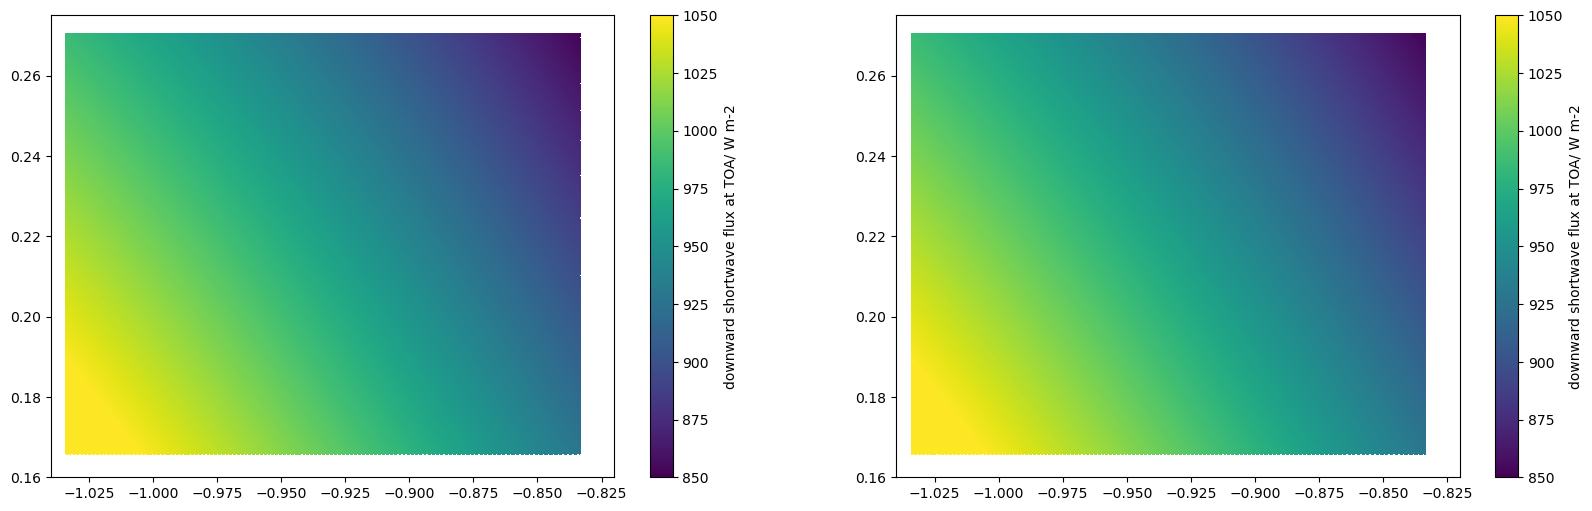

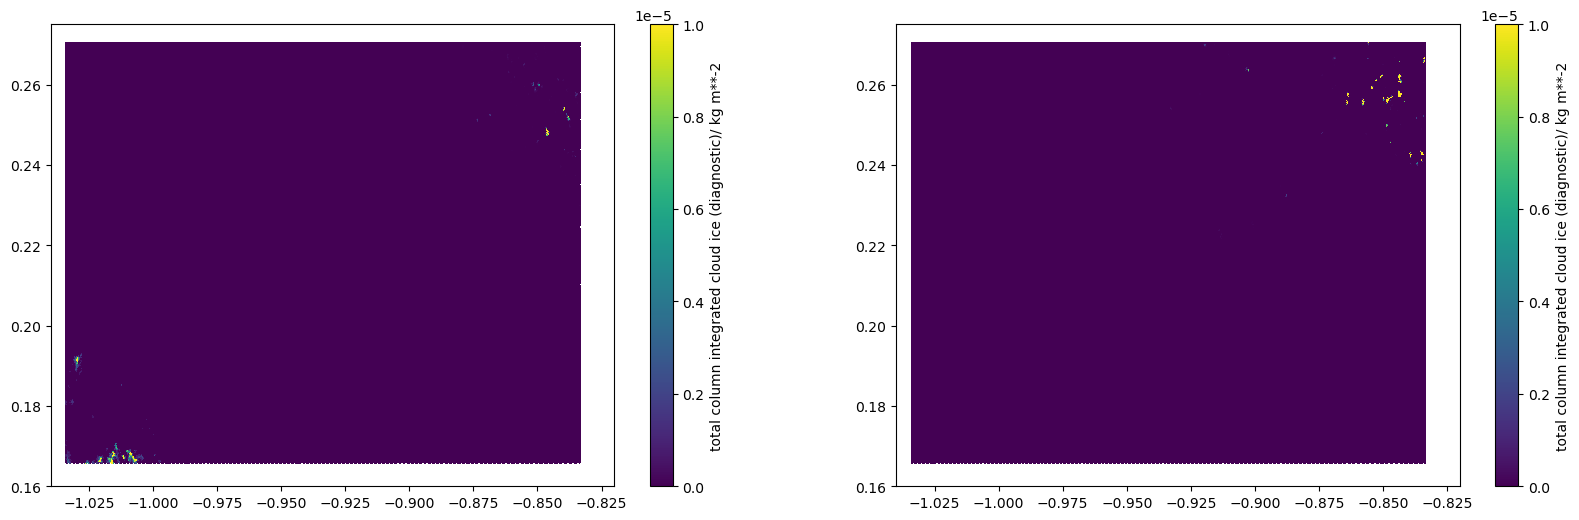

In [13]:
import plot_utils as pu
import matplotlib.pyplot as plt

var = 'sod_t'
fig, axs = plt.subplots(1,2, figsize=(20,6))
for ax, exp in zip(axs, d1.exp.values):
    ax = pu.ax_triangles(ax, d1.sel({'cloudcover':0.5, 'icefilter':0, 'exp':exp}), var, vminmax=(850, 1050))
# for ax, ice in zip(axs, d1.icefilter.values):
#     ax = pu.ax_triangles(ax, d1.sel({'cloudcover':0.5, 'icefilter':ice, 'exp':'warming'}), 'sod_t', vminmax=(850, 1050))
    ax.set_xlim(-1.04, -0.82)
    ax.set_ylim(0.16, 0.275)
fig.show()

var = 'tqi_dia'
fig, axs = plt.subplots(1,2, figsize=(20,6))
for ax, exp in zip(axs, d1.exp.values):
    ax = pu.ax_triangles(ax, d1.sel({'cloudcover':0.5, 'icefilter':0, 'exp':exp}), var, vminmax=(0, 1e-5))
    ax.set_xlim(-1.04, -0.82)
    ax.set_ylim(0.16, 0.275)
fig.show()

In [5]:
pu.ax_triangles?

Signature:
pu.ax_triangles(
    ax,
    dataset,
    var,
    cell_vertex_varname='vertex_of_cell',
    vminmax=(None, None),
    cmap='viridis',
    edgecolor='none',
    set_xy_lim=False,
)
Docstring:
Plot triangular mesh on a given Axes object.

This function plots a triangular mesh on a given Axes object using the matplotlib.tripcolor method. The triangular
mesh is defined by the vertices of cells provided in the dataset. Optionally, a variable can be mapped onto the mesh
using a colormap.

Args:
    ax (matplotlib.axes.Axes): The Axes object onto which the triangular mesh will be plotted.
    dataset (xarray.Dataset): The dataset containing the mesh information.
    var (str or None): The name of the variable to be mapped onto the mesh. If None, only the mesh will be plotted
        without coloring.
    cell_vertex_varname (str, optional): The name of the variable in the dataset containing the vertex indices of
        cells. Defaults to 'vertex_of_cell'.
    vminmax (tuple, opti

In [46]:
exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'
domain='DOM01'

data = pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))
data = pp.add_grid(data)
data = pp.cut_borders(data)
data = data.mean(dim='cell')
data = data['sod_t']

/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


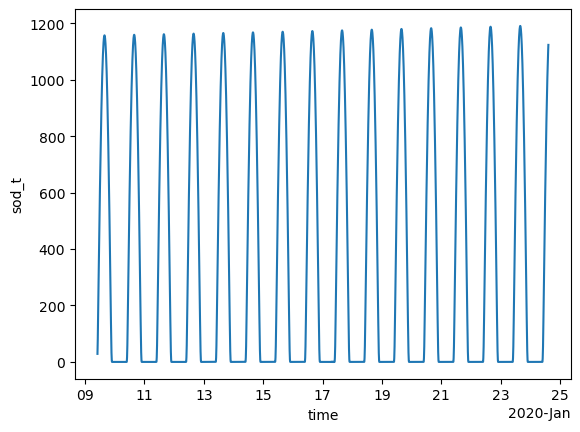

In [47]:
data.plot()

In [48]:
def nan_to_boolean(data_array: xr.DataArray) -> xr.DataArray:
    """
    Convert an xr.DataArray to a boolean array indicating NaN values.

    Parameters:
    - data_array: xr.DataArray

    Returns:
    - xr.DataArray: Boolean array with True where NaNs are present.
    """
    return xr.DataArray(np.isnan(data_array), dims=data_array.dims, coords=data_array.coords)
    
sum(nan_to_boolean(data).values)

np.int64(1)

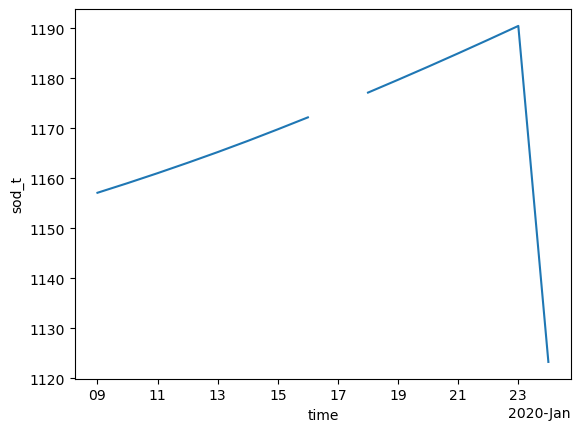

In [54]:
def daily_maximum(data_array: xr.DataArray) -> xr.DataArray:
    return data_array.resample(time='1D').max(skipna=True)

daily_maximum(data).plot()

In [55]:
sum(nan_to_boolean(daily_maximum(data)).values)

np.int64(0)

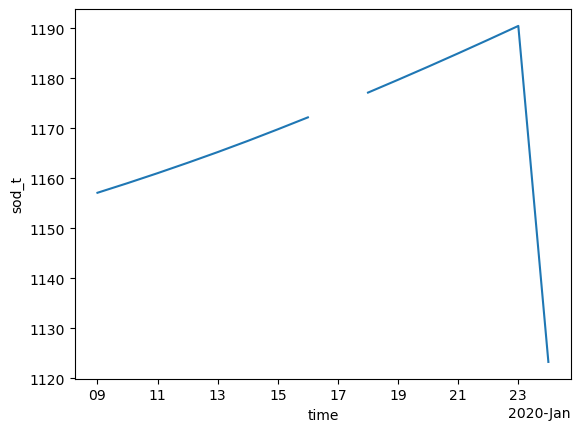

In [56]:
def daily_maximum(data_array: xr.DataArray) -> xr.DataArray:
    return data_array.resample(time='1D').max(skipna=True)

daily_maximum(data).plot()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

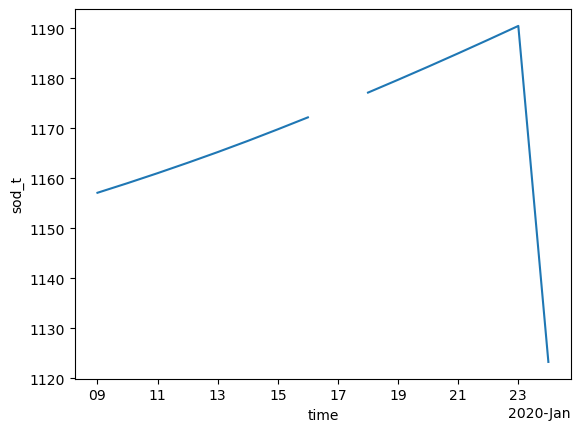

In [57]:
sum(nan_to_boolean(daily_maximum(data).plot()).values)

In [ ]:
def daily_average(data_array: xr.DataArray) -> xr.DataArray:
    return data_array.resample(time='1D').mean(skipna=True)

daily_average(data).plot()

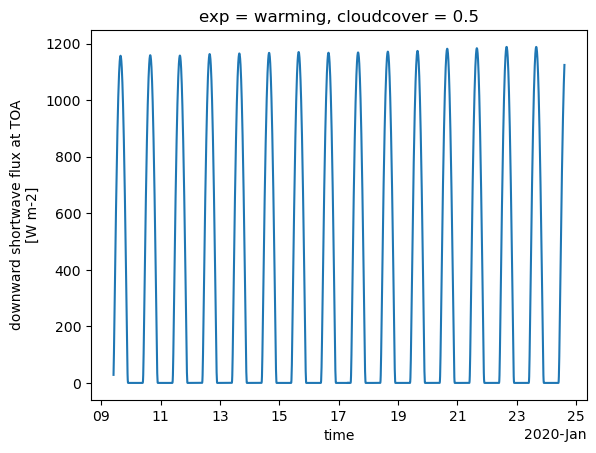

In [38]:
import os 
import xarray as xr
import pandas as pd
import time 
import datetime

dirname = '/scratch/m/m300872/temp'
files = [os.path.join(dirname, f) for f in os.listdir(dirname)]
files = sorted(files)
data = xr.open_mfdataset(files, combine='nested', concat_dim='time')

data = data.sortby(data.time)
data = data.sel({'exp':'warming', 'cloudcover':0.5})['sod_t']
data.plot()

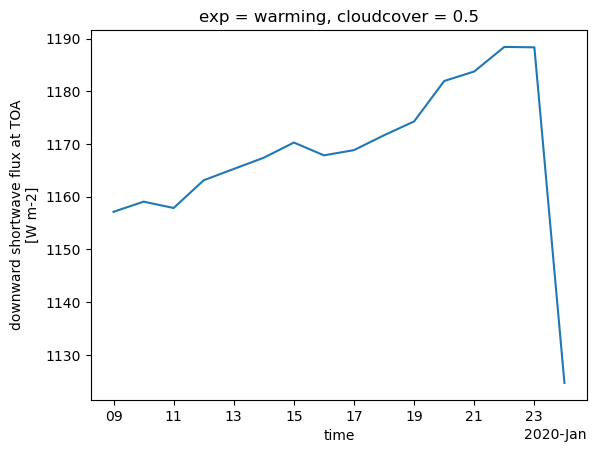

In [39]:
def daily_average(data_array: xr.DataArray) -> xr.DataArray:
    return data_array.resample(time='1D').mean()

daily_maximum(data).plot()

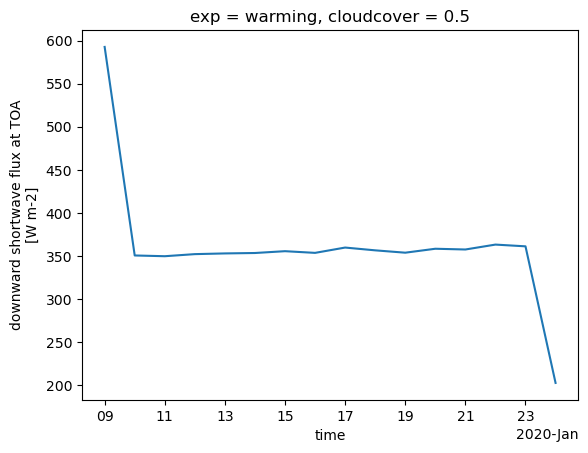

In [40]:
def daily_average(data_array: xr.DataArray) -> xr.DataArray:
    return data_array.resample(time='1D').mean()

daily_average(data).plot()

In [45]:
import xarray as xr
import numpy as np

def count_nans_per_dimension(data_array: xr.DataArray) -> dict:
    """
    Count the number of NaN values along each dimension of an xr.DataArray.

    Parameters:
    - data_array: xr.DataArray

    Returns:
    - dict: A dictionary with dimension names as keys and lists of NaN counts as values.
    """
    nan_counts = {}
    for dim in data_array.dims:
        # Sum over all dimensions except the current one to count NaNs along the current dimension
        nan_counts[dim] = np.isnan(data_array).sum(dim=[d for d in data_array.dims if d != dim]).values.tolist()
    return nan_counts


def nan_to_boolean(data_array: xr.DataArray) -> xr.DataArray:
    """
    Convert an xr.DataArray to a boolean array indicating NaN values.

    Parameters:
    - data_array: xr.DataArray

    Returns:
    - xr.DataArray: Boolean array with True where NaNs are present.
    """
    return xr.DataArray(np.isnan(data_array), dims=data_array.dims, coords=data_array.coords)
    
sum(nan_to_boolean(data).values)

np.int64(2)

In [14]:
def daily_averaged(data):
    points_per_24h = int(pd.Timedelta('24h') / pd.to_timedelta(data.time.values[1] - data.time.values[0])) # determine the frequency
    chunk_index = xr.DataArray(np.arange(len(data.time)) // points_per_24h, dims='time', coords={'time': data.time})
    data = data.groupby(chunk_index).mean(skipna=True, keep_attrs=True).rename({'group':'day'})
    return data


directory = '/scratch/m/m300872/temp'
files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if 'DOM01' in f])
files = [f for f in files if 'sub' not in f]
len(files)
# data = xr.open_mfdataset()
# data = daily_averaged(data)
# data = data.isel({'day':slice(1,-1)})
# fh.disk_data_from_keywords(directory, 'DOM01')
# data

782

In [53]:
import xarray as xr
import pandas as pd
import numpy as np

def load_daily_averaged_subsampled():
    data = xr.open_dataset('./data/dom01_subset.nc')
    data = data.mean(dim='cell', keep_attrs=True)

    points_per_24h = int(pd.Timedelta('24h') / pd.to_timedelta(data.time.values[1] - data.time.values[0])) # determine the frequency
    chunk_index = xr.DataArray(np.arange(len(data.time)) // points_per_24h, dims='time', coords={'time': data.time})
    data = data.groupby(chunk_index).mean(skipna=True, keep_attrs=True).rename({'group':'day'})
    return data

data_s = load_daily_averaged_subsampled()
data_s = data_s.isel({'day':slice(1,None)})
data_s

<xarray.Dataset> Size: 4kB
Dimensions:        (day: 7, cloudcover: 3, exp: 2)
Coordinates:
  * exp            (exp) <U7 56B 'warming' 'control'
  * cloudcover     (cloudcover) float64 24B 0.0 0.5 1.0
  * day            (day) int64 56B 1 2 3 4 5 6 7
Data variables: (12/24)
    qv_2m          (day, cloudcover, exp) float32 168B 0.01878 ... 0.01601
    tot_prec       (day, cloudcover, exp) float32 168B 4.161 2.993 ... 24.0 12.8
    rain_gsp_rate  (day, cloudcover, exp) float32 168B 9.004e-06 ... 2.529e-05
    sou_t          (day, cloudcover, exp) float32 168B -44.65 -51.85 ... -88.1
    t_2m           (day, cloudcover, exp) float32 168B 302.6 298.7 ... 298.7
    shfl_s         (day, cloudcover, exp) float32 168B -26.42 -22.85 ... -15.83
    ...             ...
    v_10m          (day, cloudcover, exp) float32 168B -4.112 -4.019 ... -2.047
    sw_net         (day, cloudcover, exp) float32 168B 306.2 295.3 ... 288.5
    rad_net        (day, cloudcover, exp) float32 168B -1.549 -4.903 ... 21.06
    fl_s           (day, cloudcover, exp) float32 168B -322.7 -248.5 ... -165.7
    energyflux     (day, cloudcover, exp) float32 168B -324.2 -253.6 ... -146.2
    albedo         (day, cloudcover, exp) float32 168B 0.1731 0.1921 ... 0.2708
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

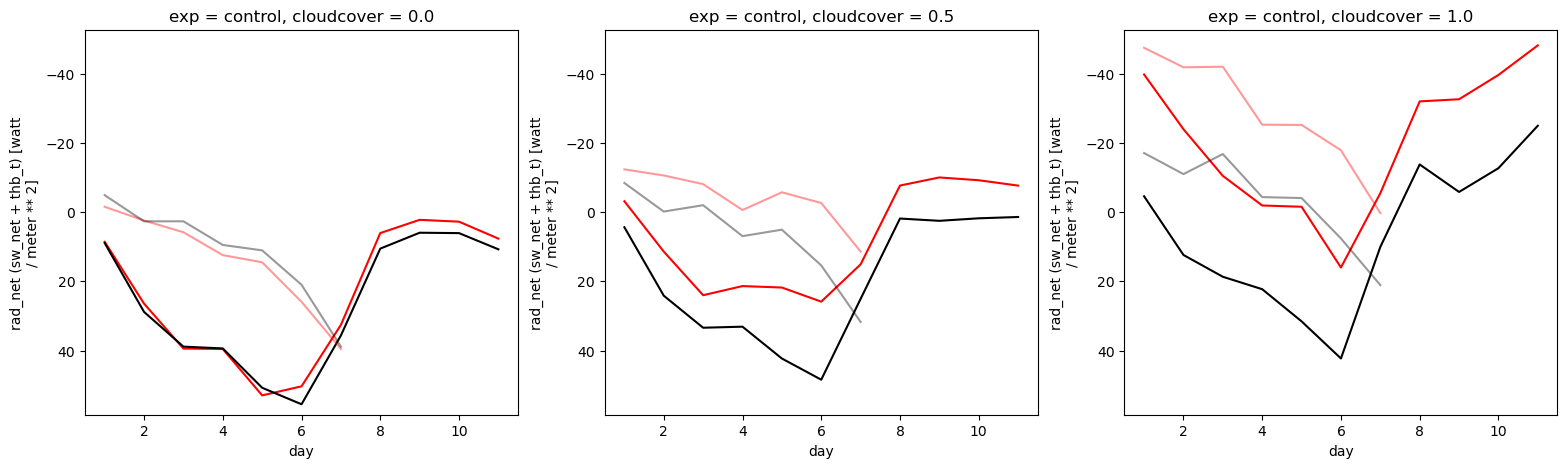

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(19,5))
x = data.day.values

for ax, cloudcover in zip(axs, [0, 0.5, 1]):
    for exp, kw in zip(data.exp.values, [{'color':'red'},{'color':'black'}]):
        y = data.sel(exp=exp).sel(cloudcover=cloudcover)['rad_net']
        y.plot(ax=ax, **kw)

for ax, cloudcover in zip(axs, [0, 0.5, 1]):
    for exp, kw in zip(data.exp.values, [{'color':'red'},{'color':'black'}]):
        y = data_s.sel(exp=exp).sel(cloudcover=cloudcover)['rad_net']
        y.plot(ax=ax, alpha=0.4, **kw)
        
y_lim = np.ravel([ax.get_ylim() for ax in axs])
for ax in axs: 
    ax.set_ylim(np.min(y_lim), np.max(y_lim))
    ax.set_ylim(ax.get_ylim()[::-1])
fig.show()

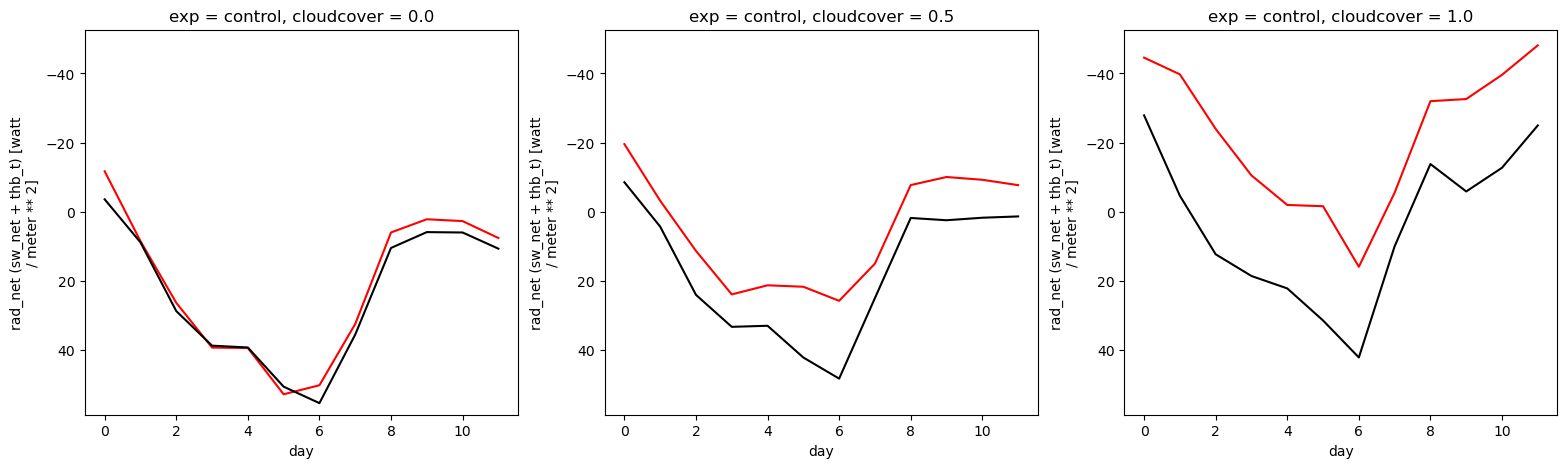

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(19,5))
x = data.day.values

for ax, cloudcover in zip(axs, [0, 0.5, 1]):
    for exp, kw in zip(data.exp.values, [{'color':'red'},{'color':'black'}]):
        y = data.sel(exp=exp).sel(cloudcover=cloudcover)['rad_net']
        y.plot(ax=ax, **kw)
        
y_lim = np.ravel([ax.get_ylim() for ax in axs])
for ax in axs: 
    ax.set_ylim(np.min(y_lim), np.max(y_lim))
    ax.set_ylim(ax.get_ylim()[::-1])
fig.show()

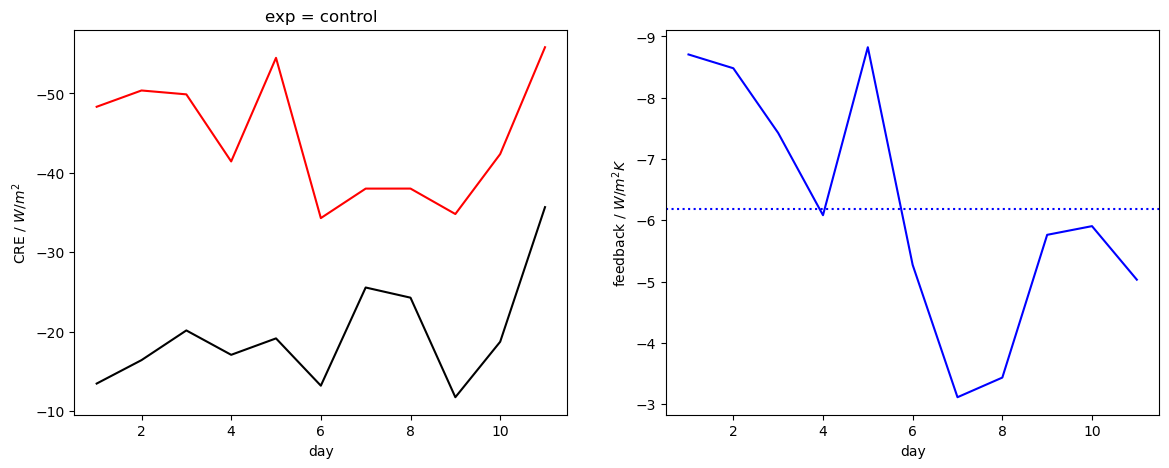

In [55]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(14,5))
x = data.day.values

ax = axs[0]
cre = data.sel(cloudcover=1)['rad_net'] - data.sel(cloudcover=0)['rad_net']

for exp, kw in zip(data.exp.values, [{'color':'red'},{'color':'black'}]):
    y = cre.sel(exp=exp)
    y.plot(ax=ax, **kw)# y.plot(ax=ax, **kw)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel('CRE / $W/m^2$')

ax = axs[1]
swfeedback = cre.sel(exp='warming') - cre.sel(exp='control')
swfeedback.values = swfeedback.values / 4
kw = {'color':'blue'}
swfeedback.plot(ax=ax, **kw)# y.plot(ax=ax, **kw)
ax.axhline(np.mean(swfeedback.values), ls=':', **kw)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel('feedback / $W/m^2K$')

fig.show()

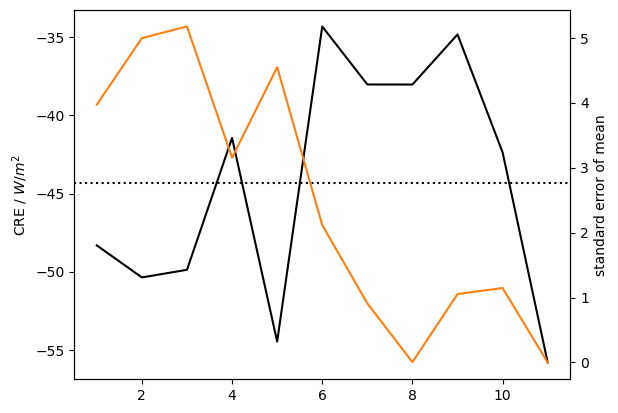

In [77]:
import numpy as np
import matplotlib.pyplot as plt

x = cre.day.values
y = cre.sel(exp='warming').values

ground_truth_mean = np.mean(y)
errors = []
for i in range(1, len(y) + 1):
    current_data = y[:i]  # Data up to the current day
    sample_mean = np.mean(current_data)
    error = np.abs(sample_mean - ground_truth_mean)
    errors.append(error)

fig, ax = plt.subplots()

ax.plot(x, y, color='black')
ax.axhline(np.mean(y), ls=':', color='black')
           
ax2 = ax.twinx()
ax2.plot(x, errors, color='tab:orange', label='standard error of mean')
ax2.set_ylabel('standard error of mean')
ax.set_ylabel('CRE / $W/m^2$')

fig.show()

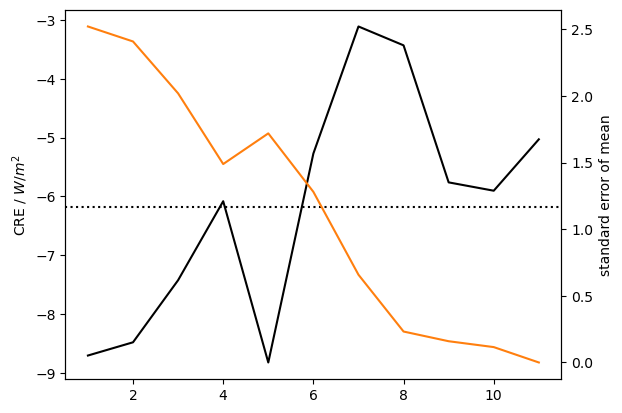

In [76]:
import numpy as np
import matplotlib.pyplot as plt

x = swfeedback.day.values
y = swfeedback.values

ground_truth_mean = np.mean(y)
errors = []
for i in range(1, len(y) + 1):
    current_data = y[:i]  # Data up to the current day
    sample_mean = np.mean(current_data)
    error = np.abs(sample_mean - ground_truth_mean)
    errors.append(error)

fig, ax = plt.subplots()

ax.plot(x, y, color='black')
ax.axhline(np.mean(y), ls=':', color='black')

ax2 = ax.twinx()
ax2.plot(x, errors, color='tab:orange', label='standard error of mean')
ax2.set_ylabel('standard error of mean')
ax.set_ylabel('CRE / $W/m^2$')

fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = cre.day.values
y = cre.sel(exp='warming').values

ground_truth_mean = np.mean(y)
errors = []
for i in range(1, len(y) + 1):
    current_data = y[:i]  # Data up to the current day
    sample_mean = np.mean(current_data)
    error = np.abs(sample_mean - ground_truth_mean)
    errors.append(error)

fig, ax = plt.subplots()

ax.plot(x, y)
ax.axhline(np.mean(y), ls=':', **kw)

ax2 = ax.twinx()
ax2.plot(x, errors, color='green', label='standard error of mean')
ax2.set_ylabel('standard error of mean')
ax.set_ylabel('CRE / $W/m^2$')

fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'cre' is your dataset and 'kw' is a dictionary of keyword arguments for plotting
fig, ax = plt.subplots()

x = cre.day.values
y = cre.sel(exp='warming').values

# Plot the original data
ax.plot(x, y)
ax.axhline(np.mean(y), ls=':', **kw)

# Ground truth mean
ground_truth_mean = np.mean(y)

# Calculate error for each day using the first x samples
errors = []

for i in range(1, len(y) + 1):
    current_data = y[:i]  # Data up to the current day
    sample_mean = np.mean(current_data)
    error = np.abs(sample_mean - ground_truth_mean)  # Absolute deviation from ground truth
    errors.append(error)

# Plot the error as a time series
ax2 = ax.twinx()  # Create a secondary y-axis
ax2.plot(x, errors, color='green', label='Deviation from Ground Truth')
ax2.set_ylabel('Deviation from Ground Truth')
ax2.legend(loc='upper right')

# Add labels and legend
ax.set_ylabel('CRE / $W/m^2$')
ax.legend(loc='upper left')

fig.show()

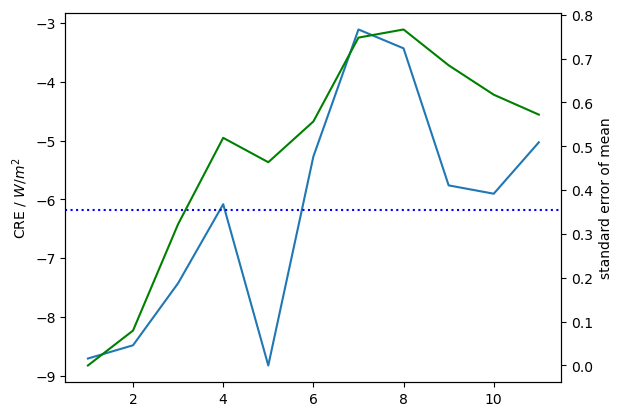

In [68]:
import numpy as np
import matplotlib.pyplot as plt

x = swfeedback.day.values
y = swfeedback.values

errors = []
for i in range(1, len(y) + 1):
    current_data = y[:i]  # Data up to the current day
    sample_mean = np.mean(current_data)
    error = np.std(current_data) / np.sqrt(i)  # Standard error of the mean
    errors.append(error)

fig, ax = plt.subplots()

ax.plot(x, y)
ax.axhline(np.mean(y), ls=':', **kw)

ax2 = ax.twinx()
ax2.plot(x, errors, color='green', label='standard error of mean')
ax2.set_ylabel('standard error of mean')
ax.set_ylabel('CRE / $W/m^2$')

fig.show()

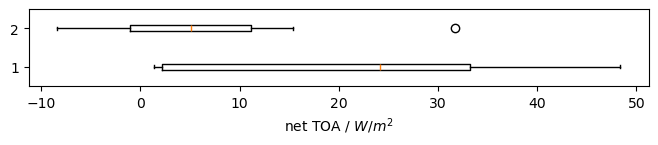

In [57]:
fig, ax = plt.subplots(figsize=(8,1))

y = [data.sel(exp='control').sel(cloudcover=0.5)['rad_net'],
     data_s.sel(exp='control').sel(cloudcover=0.5)['rad_net']]

y = data.sel(exp='control').sel(cloudcover=0.5)['rad_net']

ax.boxplot(y, vert=False)
ax.set_xlabel('net TOA / $W/m^2$')
fig.show()

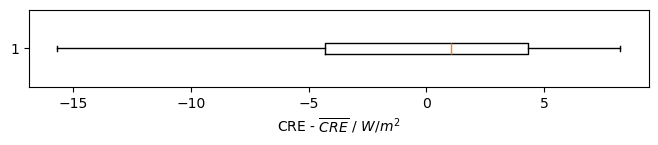

In [43]:
fig, ax = plt.subplots(figsize=(8,1))

c_err = cre.sel(exp='control')
c_err = c_err - np.mean(c_err.values)
ax.boxplot(c_err, vert=False)
ax.set_xlabel('CRE - $\\overline{CRE}$ / $W/m^2$')
fig.show()

## short wave

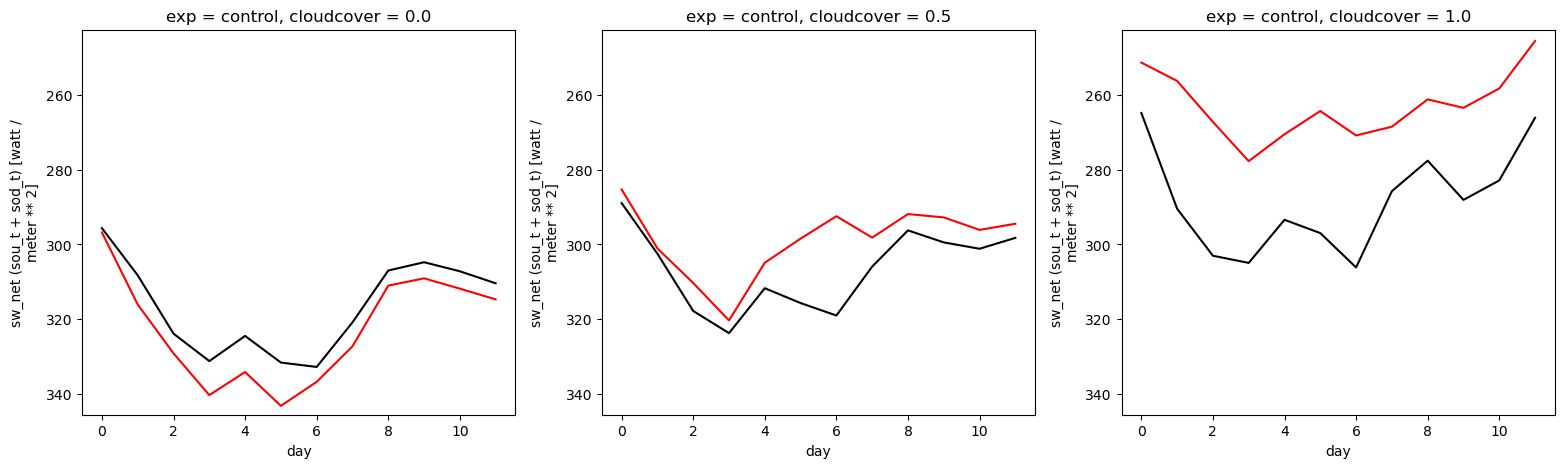

In [44]:
fig, axs = plt.subplots(1,3, figsize=(19,5))
x = data.day.values

for ax, cloudcover in zip(axs, [0, 0.5, 1]):
    for exp, kw in zip(data.exp.values, [{'color':'red'},{'color':'black'}]):
        y = data.sel(exp=exp).sel(cloudcover=cloudcover)['sw_net']
        y.plot(ax=ax, **kw)
        
y_lim = np.ravel([ax.get_ylim() for ax in axs])
for ax in axs: 
    ax.set_ylim(np.min(y_lim), np.max(y_lim))
    ax.set_ylim(ax.get_ylim()[::-1])
fig.show()

In [15]:
directory = '/scratch/m/m300872/temp'
data2 = xr.open_mfdataset(sorted([os.path.join(directory, f) for f in os.listdir(directory) if 'DOM02' in f]))
data2

<xarray.Dataset> Size: 63kB
Dimensions:        (cloudcover: 3, exp: 2, time: 113)
Coordinates:
  * exp            (exp) <U7 56B 'warming' 'control'
  * time           (time) datetime64[ns] 904B 2020-01-16T13:40:00 ... 2020-01...
  * cloudcover     (cloudcover) float64 24B 0.0 0.5 1.0
Data variables: (12/23)
    lhfl_s         (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    u_10m          (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    pres_sfc       (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    clct           (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    shfl_s         (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    qv_2m          (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    ...             ...
    thb_t          (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    sw_net         (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    rad_net        (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    fl_s           (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    energyflux     (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
    albedo         (cloudcover, exp, time) float32 3kB dask.array<chunksize=(3, 2, 3), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          3c7523ba-f78c-c23e-6654-012805ba3300
    uuidOfParHGrid:       6b59890b-99f3-939b-e76a-0a3ad2e43140

In [82]:
def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

data = get_data(time_index=100)
data

/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/m/m300872/.conda/envs/warmeurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dim

<xarray.Dataset> Size: 379MB
Dimensions:        (cell: 2154774, exp: 2)
Coordinates:
    lat            (cell) float64 17MB 9.501 9.5 9.507 ... 13.02 13.01 13.01
    lon            (cell) float64 17MB -47.75 -47.76 -47.77 ... -51.36 -51.37
  * cell           (cell) int64 17MB 396191 396193 396214 ... 4469910 4469911
  * exp            (exp) object 16B 'warming' 'control'
    time           datetime64[ns] 8B 2020-01-10T03:20:00
Data variables: (12/19)
    shfl_s         (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    rain_gsp_rate  (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    sou_t          (exp, cell) float32 17MB dask.array<chunksize=(1, 905712), meta=np.ndarray>
    tqv_dia        (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    u_10m          (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    sod_t          (exp, cell) float32 17MB dask.array<chunksize=(1, 905712), meta=np.ndarray>
    ...             ...
    qv_2m          (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    rh_2m          (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    sob_t          (exp, cell) float32 17MB dask.array<chunksize=(1, 905712), meta=np.ndarray>
    tqi_dia        (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    t_seasfc       (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
    tot_prec       (exp, cell) float32 17MB dask.array<chunksize=(1, 251586), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

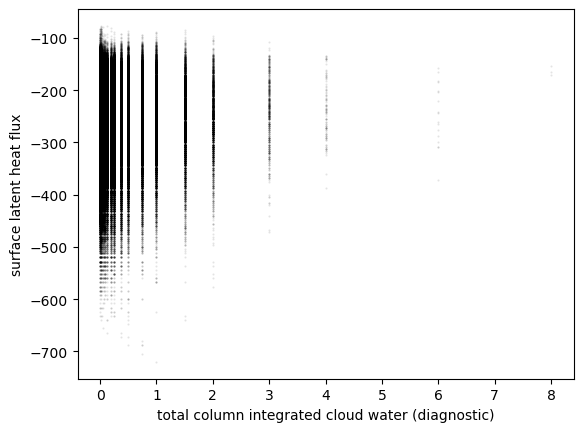

In [87]:
x = data.sel(exp='control')['tqc_dia']
y = data.sel(exp='control')['lhfl_s']

fig, ax = plt.subplots()
ax.scatter(x.values,y.values, color='black', marker='.', s=1, alpha=0.1)
ax.set_xlabel(x.attrs['long_name'])
ax.set_ylabel(y.attrs['long_name'])
fig.show()